#Paquetes necesarios

In [3]:
import cv2  
import numpy as np
import matplotlib.pyplot as plt

Carga imagen y convierte a RGB

(4080, 3060, 3)


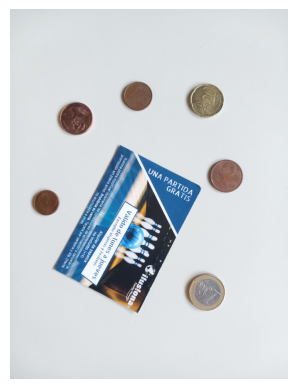

In [4]:
#Carga imagen ejemplo con monedas
img = cv2.imread('monedas_tarjeta.jpg') 
print(img.shape)
#Recordando que OpenCV lee las imágenes en BGR, por lo que convertimos para visualizr RGB
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

plt.axis("off")
plt.imshow(img_rgb) 
plt.show()

Convierte a gris y muestra histograma

(0.0, 256.0)

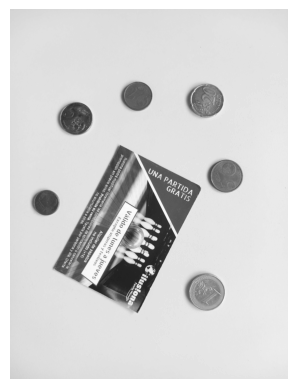

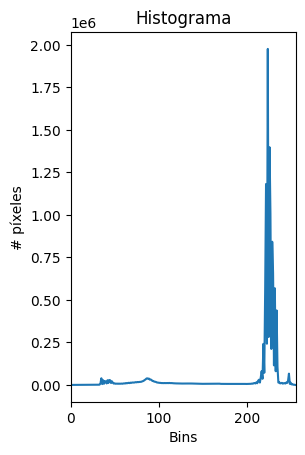

In [5]:
#Convierte la imagen a todos de gris, mostrando el resultado
img_gris = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

#Cálculo del histograma con 256 bins de una imagen en escala de grises
hist = cv2.calcHist([img_gris], [0], None, [256], [0, 256])

plt.figure()
plt.axis("off")
plt.imshow(img_gris, cmap='gray')

# Histograma sin normalizar
plt.figure()
plt.subplot(1, 2, 1)
plt.title("Histograma")
plt.xlabel("Bins")
plt.ylabel("# píxeles")
plt.plot(hist)
plt.xlim([0, 256])

Cuenta elementos tras umbralizar

Text(0.5, 1.0, 'OTSU invertida')

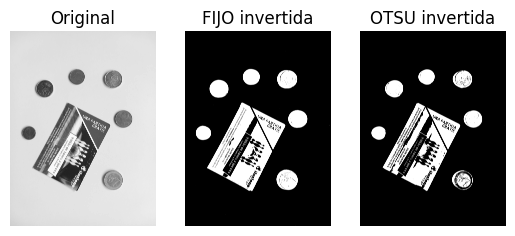

In [6]:
#Dos umbralizados. Te invito a probar con parámetros, aplicar filtro previo, etc.
umbral = 200
# Umbralizado binaria invertido, dado que por defecto se asume objetos en blanco
res,img_th1 = cv2.threshold(img_gris,umbral,255,cv2.THRESH_BINARY_INV)
# Umbralizado con método de Otsu
ret2,img_th2 = cv2.threshold(img_gris,0,255,cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)

plt.subplot(1, 3, 1)
plt.axis("off")
plt.imshow(img_gris,cmap='gray') 
plt.title('Original')

plt.subplot(1, 3, 2)
plt.axis("off")
plt.imshow(img_th1,cmap='gray') 
plt.title('FIJO invertida')

plt.subplot(1, 3, 3)
plt.axis("off")
plt.imshow(img_th2,cmap='gray') 
plt.title('OTSU invertida')



Búsqueda de componentes y sus contornos

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


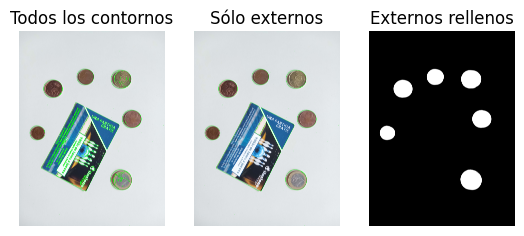

Número de monedas: 6


In [6]:
#Localiza contornos en imagen obtenida con umbral fijo
#findContours está diseñada para imágenes con la figura en blanco y el fondo negro
#La imagen de entrada debe ser de un canal y 8 bits excepto en los modos RETR_CCOMP o RETR_FLOODFILL
#hierarchy contiene información sobre el nivel del contorno, relaciones paterno-filiales

# Inicializa un contador para el número de objetos circulares
num_objetos_circulares = 0

# Define un umbral para considerar si un objeto es circular
umbral_circularidad = 0.9

#Obtiene todos los contornos, externos e internos
contornos, hierarchy = cv2.findContours(
    img_th1, #imagen
    cv2.RETR_TREE, #Modo de recuperación (lista, árbol, nivel superior)
    cv2.CHAIN_APPROX_SIMPLE #Método de aproximación del contorno
    )
#Obtiene únicamente los contornos externos
contornos2, hierarchy2 = cv2.findContours(img_th1, 
    cv2.RETR_EXTERNAL , 
    cv2.CHAIN_APPROX_SIMPLE)

# Dibuja sobre la imagen de entrada todos los contornos en verde
#Cada vez que quiere pintar convierte img para no tener restos
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
cv2.drawContours(img_rgb, contornos, -1, (0,255,0), 3)

plt.subplot(131)
plt.axis("off")
plt.imshow(img_rgb) 
plt.title('Todos los contornos')

# Dibuja sobre la imagen de entrada sólo contornos externos
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
cv2.drawContours(img_rgb, contornos2, -1, (0,255,0), 3)

plt.subplot(132)
plt.axis("off")
plt.imshow(img_rgb) 
plt.title('Sólo externos')

#Dibuja contornos externos rellenos en imagen vacía
#crea imagen vacíanegra
img_cont = np.zeros(img_rgb.shape)
for c in contornos2:
    #Área delcontorno
    area = cv2.contourArea(c)

    #Dimensión mínima (útil en ocasiones)
    if area > 10:
        #Perímetro delcontorno
        perimetro = cv2.arcLength(c,True)
        #Contenedor alineado con ejes de la imagen
        x,y,w,h = cv2.boundingRect(c)
        #Mínimo contenedor ajustado para el contorno
        rect = cv2.minAreaRect(c)
        #Mínimo círculo que lo contiene
        (cx,cy),radio = cv2.minEnclosingCircle(c)
        #Elipse ajustada al contorno
        if c.shape[0] > 5:
            elipse = cv2.fitEllipse(c)
            #Para determinadas tareas nos interesará mostrar estos valores
            #print(area, perimetro, rect, cx,cy,radio, elipse)
    (cx, cy), radio = cv2.minEnclosingCircle(c)
    area_circulo = np.pi * (radio ** 2)
    
    # Calcula la circularidad como el área del contorno dividido por el área del círculo mínimo
    circularidad = area / area_circulo
    
    # Si la circularidad está por encima del umbral, consideramos el objeto como circular
    if circularidad >= umbral_circularidad:
        num_objetos_circulares += 1
        #Dibuja los contornos
        cv2.drawContours(img_cont, [c], -1, (255,255,255), -1)

plt.subplot(133)
plt.axis("off")
plt.imshow(img_cont) 
plt.title('Externos rellenos')
plt.show()
print(f"Número de monedas: {num_objetos_circulares}")


TAREA: Captura una o varias imágenes con monedas no solapadas y algún objeto que no lo sea. Filtra los contornos que no se correpondan con monedas, y muestra el número total de monedas presentes en la imagen.

Una alternativa consiste en contar círculos utilizando la Transformada de Hough. La selección de parámetros puede ser "divertida", más [información](https://docs.opencv.org/4.x/da/d53/tutorial_py_houghcircles.html)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


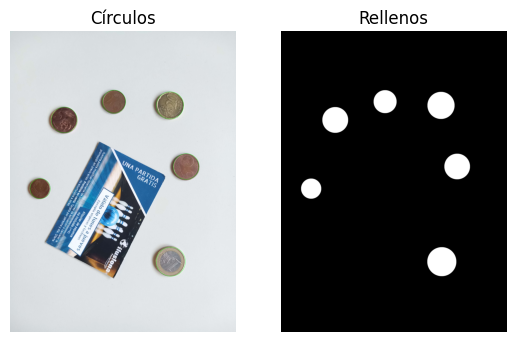

---------------------------------------
Cantidad de monedas
---------------------------------------
1 euro: 1 monedas
20 centimos: 1 monedas
2 centimos: 1 monedas
5 centimos: 2 monedas
1 centimo: 1 monedas
---------------------------------------
Total: 1.33 euros


In [20]:
#Conversión a gris
gris = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
#Suaviza altas frecuencias
pimg = cv2.medianBlur(gris, 7)
#Localiza Círculos
circ = cv2.HoughCircles(
        pimg,  # imagen 
        cv2.HOUGH_GRADIENT,  # tipo de detección
        1.5,
        650,  # distancia mínima entre círculos
        param1=200, # Valor del gradiente
        param2=120, #Umbral acumulador
        minRadius=60,  # radio mínimo
        maxRadius=250,  # radio máximo
    )
coin_counters = {
    "1 euro": 0,
    "20 centimos": 0,
    "2 centimos": 0,
    "5 centimos": 0,
    "1 centimo": 0,
}
#Dibuja sobre entrada  e imagen vacía
img_cont = np.zeros(img_rgb.shape)
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
for det in circ[0]:
        x_coor, y_coor, det_radio = det
        cv2.circle(img_rgb,(int(x_coor), int(y_coor)),
            int(det_radio),(0, 255, 0), 2)
        cv2.circle(img_cont,(int(x_coor), int(y_coor)),
            int(det_radio),(255, 255, 255), -1)

# Inicializa una lista para almacenar las dimensiones de las monedas
coin_dimensions = []

for det in circ[0]:
    x_coor, y_coor, det_radio = det
    # Calcula el diámetro de la moneda (el doble del radio)
    diameter = round(2 * det_radio)
    # Calcula el área del círculo (pi * r^2)
    area = round(np.pi * (det_radio ** 2))
    coin_dimensions.append((diameter, area))
coin_dimensions.sort()
# Identifica las monedas y suma a los contadores
for dimension in coin_dimensions:
    if dimension == coin_dimensions[-1]:
        coin_counters["1 euro"] += 1
    elif dimension == coin_dimensions[-2]:
        coin_counters["20 centimos"] += 1
    elif dimension == coin_dimensions[1]:
        coin_counters["2 centimos"] += 1
    elif dimension == coin_dimensions[0]:
        coin_counters["1 centimo"] += 1
    else:
        coin_counters["5 centimos"] += 1


    

#Muestra resultado
plt.subplot(121)
plt.axis("off")
plt.imshow(img_rgb) 
plt.title('Círculos')

plt.subplot(122)
plt.axis("off")
plt.imshow(img_cont) 
plt.title('Rellenos')

plt.show()
print("---------------------------------------")
print("Cantidad de monedas")
print("---------------------------------------")
# Imprime los resultados
for coin, count in coin_counters.items():
    print(f"{coin}: {count} monedas")
total = (
    coin_counters["1 euro"] +
    coin_counters["1 centimo"] * 0.01 +
    coin_counters["2 centimos"] * 0.02 +
    coin_counters["5 centimos"] * 0.05 +
    coin_counters["20 centimos"] * 0.20
)
print("---------------------------------------")
print("Total: " + str(total) + " euros")


TAREA: Captura una o varias imágenes con monedas no solapadas, y otras con monedas solapadas. Identificada una moneda de un euro en la imagen, por ejemplo con un clic de ratón, calcular la cantidad de dinero presente en la imagen. ¿Qué problemas han observado?




Clasificación de microplásticos

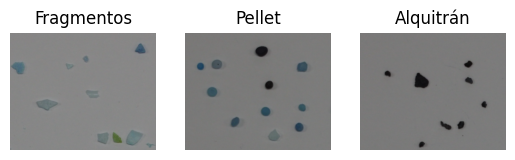

In [7]:
#Cargamos tres subimágenes de cada uno de los tres tipos considerados (el alquitrán efectivamenet no es microplástico)
imgF = cv2.imread('FRA.png') 
imgP = cv2.imread('PEL.png') 
imgT = cv2.imread('TAR.png') 

#Mostramos
plt.subplot(131)
plt.axis("off")
plt.imshow(imgF) 
plt.title('Fragmentos')
plt.subplot(132)
plt.axis("off")
plt.imshow(imgP) 
plt.title('Pellet')
plt.subplot(133)
plt.axis("off")
plt.imshow(imgT) 
plt.title('Alquitrán')
plt.show()

1 euro: 1 monedas
20 centimos: 1 monedas
2 centimos: 1 monedas
5 centimos: 2 monedas
1 centimo: 1 monedas


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


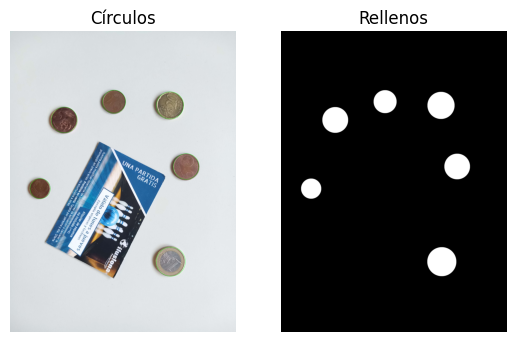

In [8]:
#Conversión a gris
gris = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
#Suaviza altas frecuencias
pimg = cv2.medianBlur(gris, 7)
#Localiza Círculos
circ = cv2.HoughCircles(
        pimg,  # imagen 
        cv2.HOUGH_GRADIENT,  # tipo de detección
        1.5,
        650,  # distancia mínima entre círculos
        param1=200, # Valor del gradiente
        param2=120, #Umbral acumulador
        minRadius=60,  # radio mínimo
        maxRadius=250,  # radio máximo
    )
coin_counters = {
    "1 euro": 0,
    "20 centimos": 0,
    "2 centimos": 0,
    "5 centimos": 0,
    "1 centimo": 0,
}
#Dibuja sobre entrada  e imagen vacía
img_cont = np.zeros(img_rgb.shape)
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
for det in circ[0]:
        x_coor, y_coor, det_radio = det
        cv2.circle(img_rgb,(int(x_coor), int(y_coor)),
            int(det_radio),(0, 255, 0), 2)
        cv2.circle(img_cont,(int(x_coor), int(y_coor)),
            int(det_radio),(255, 255, 255), -1)

# Inicializa una lista para almacenar las dimensiones de las monedas
coin_dimensions = []

for det in circ[0]:
    x_coor, y_coor, det_radio = det
    # Calcula el diámetro de la moneda (el doble del radio)
    diameter = round(2 * det_radio)
    # Calcula el área del círculo (pi * r^2)
    area = round(np.pi * (det_radio ** 2))
    coin_dimensions.append((diameter, area))
coin_dimensions.sort()
# Identifica las monedas y suma a los contadores
for dimension in coin_dimensions:
    if dimension == coin_dimensions[-1]:
        coin_counters["1 euro"] += 1
    elif dimension == coin_dimensions[-2]:
        coin_counters["20 centimos"] += 1
    elif dimension == coin_dimensions[1]:
        coin_counters["2 centimos"] += 1
    elif dimension == coin_dimensions[0]:
        coin_counters["1 centimo"] += 1
    else:
        coin_counters["5 centimos"] += 1

# Imprime los resultados
for coin, count in coin_counters.items():
    print(f"{coin}: {count} monedas")

#Muestra resultado
plt.subplot(121)
plt.axis("off")
plt.imshow(img_rgb) 
plt.title('Círculos')

plt.subplot(122)
plt.axis("off")
plt.imshow(img_cont) 
plt.title('Rellenos')

plt.show()

TAREA: Estas tres imágenes han sido extraidas de las imágenes de mayor tamaño contenidas en la carpeta. Determina patrones geométricos para cada una de las tres clases y evalúa los aciertos y fallos con las imágenes completas la matriz de confusión. Para cada clase, determina el número de muestras que se clasifican correctamente de dicha clase, y el número de muestras que se clasifica incorrectamente por cada una de las otras dos clases.

El el trabajo [SMACC: A System for Microplastics Automatic Counting and Classification](https://doi.org/10.1109/ACCESS.2020.2970498), las características geométricas utilizadas en dicho trabajo fueron:

- Área en píxeles
- Perímetro en píxeles
- Compacidad (relación del cuadrado del perímetro con el área)
- Relación del área con la del contenedor
- Relación del ancho y el alto del contenedor
- Relación entre los ejes de la elipse ajustada
- Definido el centroide, relación entre las distancias menor y mayor al contorno

Si no se quedan satisfechos con la segmentación obtenida, es el mundo real, también en el README comento técnicas recientes de segmentación, que podrían despertar su curiosidad.

Las métricas se utilizan para mostrar la bondad de un clasificador, la siguiente celda obtiene varias para un conjunto de datos imaginario (y con etiquetas aleatorias). Si bien las trataremos con más detalle en teoría, muestro un repertorio de ellas, dando más peso a la matriz de confusión.

¿Qué es una matriz de confusión?
Se utiliza para mostrar el comportamiento de un clasificador par alas distintas clases consideradas, se relacionan las etiquetas de las muestras anotadas frente a las predichas por el clasificador. Se busca una matriz diagonal, pero la perfección es infrecuente

In [128]:
import cv2
import numpy as np

def calcular_patrones(imagen):
    # Convertir la imagen a escala de grises
    imagen_gris = cv2.cvtColor(imagen, cv2.COLOR_BGR2GRAY)
    
    # Aplicar umbral a la imagen en escala de grises
    _, img_th1 = cv2.threshold(imagen_gris, umbral, 255, cv2.THRESH_BINARY_INV)
    
    # Encontrar contornos en la imagen binarizada
    contornos, _ = cv2.findContours(imagen_gris, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
 #Obtiene únicamente los contornos externos
    contornos2, hierarchy2 = cv2.findContours(img_th1, cv2.RETR_EXTERNAL , cv2.CHAIN_APPROX_SIMPLE)
    # Inicializar listas para almacenar patrones de todos los contornos
    areas = []
    perimetros = []
    compacidades = []
    relaciones_area_contenedor = []
    relaciones_ancho_alto = []

    
    for contorno in contornos2:

        # Calcular el área
        area = cv2.contourArea(contorno)
        if(area!=0.0):
            areas.append(area)
            
            # Calcular el perímetro
            perimetro = cv2.arcLength(contorno, True)
            perimetros.append(perimetro)
            
            # Calcular la compacidad
            compacidad = (perimetro ** 2) / (4 * 3.1415 * area)
            compacidades.append(compacidad)
            
            # Calcular la relación del área con el del contenedor
            x, y, w, h = cv2.boundingRect(contorno)
            area_contenedor = w * h
            relacion_area_contenedor = area / area_contenedor
            relaciones_area_contenedor.append(relacion_area_contenedor)
            
            # Calcular la relación del ancho y el alto del contenedor
            relacion_ancho_alto = w / h
            relaciones_ancho_alto.append(relacion_ancho_alto)
            

    
    # Calcular los valores promedio de los patrones
    patron_promedio = np.array([
        float(f'{np.mean(areas):.2f}'),
        float(f'{np.mean(perimetros):.2f}'),
        float(f'{np.mean(compacidades):.2f}'),
        float(f'{np.mean(relaciones_area_contenedor):.2f}'),
        float(f'{np.mean(relaciones_ancho_alto):.2f}')
    ])





    return patron_promedio

# Cargar imágenes
fra = cv2.imread("FRA.png")
pel = cv2.imread("PEL.png")
tar = cv2.imread("TAR.png")

# Calcular los patrones promedio para cada imagen
patron_fragmentos = calcular_patrones(fra)
patron_pellet = calcular_patrones(pel)
patron_alquitran = calcular_patrones(tar)

# Configurar el formato de visualización de numpy
print(patron_alquitran)
print(patron_pellet)
print(patron_fragmentos)



[2.75644e+03 1.96120e+02 1.41000e+00 6.10000e-01 1.01000e+00]
[1.03002e+03 1.07400e+02 3.89000e+00 4.00000e-01 1.09000e+00]
[40.66 28.97  2.99  0.28  1.38]


115
[18.0, 15.656854152679443, 1.0837758057822497, 0.6, 0.8333333333333334]
[13.5, 13.656854152679443, 1.1426370528762697, 0.525, 1.0416666666666667]
[16.333333333333332, 18.485281189282734, 1.7166914741266064, 0.4373015873015873, 0.888888888888889]
[291.625, 120.20026922225952, 4.508428398916329, 0.4313335711643148, 0.9072327044025158]
[361.8, 116.76265387535095, 3.869610324972708, 0.48398577585037084, 0.8609212986571478]
[490.9166666666667, 120.85162214438121, 3.4576693249371533, 0.5083196321295588, 0.8962962041655094]
[421.2142857142857, 104.56259427751813, 3.14041186575178, 0.48332158944438375, 0.9111110321418652]
[376.0, 98.30813394486904, 3.244930656597437, 0.4472119463193913, 0.9152777086796875]
[335.94444444444446, 89.3738407029046, 3.0671550660628, 0.43852702106697217, 0.9088182807311509]
[319.4, 89.90336130857467, 3.1787460175745417, 0.4301951522936083, 0.8712697859913691]
[291.22727272727275, 82.8432957909324, 3.0039088408350323, 0.4342683202669166, 0.9056998054466991]
[276.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


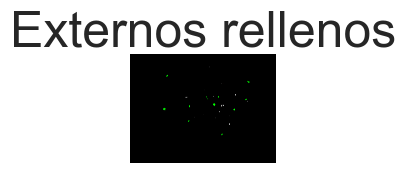

391
[1.0, 4.0, 1.273277096928219, 0.25, 1.0]
[1.0, 5.414213538169861, 2.4919392144234216, 0.1875, 1.5]
[2.3333333333333335, 7.771236101786296, 2.48829820707807, 0.2175925925925926, 1.6666666666666667]
[2.5, 7.7426406145095825, 2.2550202460786495, 0.22569444444444445, 1.4375]
[5.5, 13.70538227558136, 3.086824085897644, 0.21626984126984125, 1.55]
[5.25, 12.754485229651133, 2.78456625440274, 0.2542989417989418, 1.4583333333333333]
[4.642857142857143, 12.193619779178075, 3.27284829766487, 0.229875283446712, 1.4404761904761905]
[4.1875, 12.126524075865746, 4.215427847923337, 0.21155753968253968, 1.3020833333333333]
[15.944444444444445, 19.975749399926926, 4.297739218830788, 0.23694003527336863, 1.4351851851851851]
[19.65, 23.48944424390793, 4.32403415348694, 0.24616528640441687, 1.6202380952380953]
[23.636363636363637, 30.035628752274945, 4.969951511990605, 0.24660372784878717, 1.663026367571822]
[21.833333333333332, 28.435028612613678, 4.944585483117254, 0.23716452830583268, 1.663329725829

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


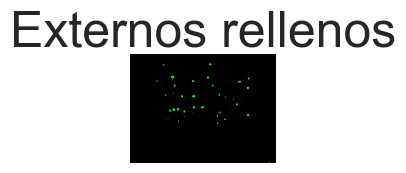

58
[4.0, 7.656854152679443, 1.1663897723102903, 0.3333333333333333, 1.3333333333333333]
[20.75, 16.19238793849945, 1.2320039612297593, 0.42708333333333337, 1.2291666666666665]
[799.8333333333334, 74.41252938906352, 1.231101121656123, 0.5267172961138479, 1.1412835249042146]
[2993.0, 159.8675308227539, 1.2833980697384806, 0.560617782505368, 1.01871432153051]
[3491.1, 185.74641938209533, 1.2695794578272523, 0.5780818426886853, 1.0193670616200123]
[3057.6666666666665, 175.64773748318353, 1.291280075732889, 0.591673140512176, 1.0994725513500103]
[2724.0, 165.70995502812522, 1.2840105577785452, 0.6067071485691791, 1.0505131521224027]
[3291.0, 188.70941372215748, 1.2910735670810092, 0.6142940169947222, 1.0295593684674627]
[2972.777777777778, 177.03036538759866, 1.2923394690157262, 0.6201710706619753, 1.0929416608599667]
[2892.2, 179.81261005401612, 1.3172144833948776, 0.6237014530089658, 1.0819233568429356]
[2816.5454545454545, 179.5123423879797, 1.306883508143478, 0.6317791580921733, 1.09302

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


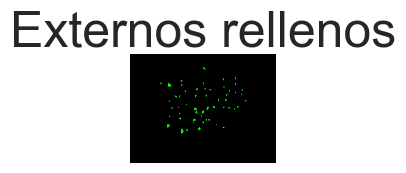

[1, 42, 0]
[26, 111, 0]
[1, 0, 56]


In [140]:
import cv2
import numpy as np

def recuento_patrones(imagen, umbral):
    # Convertir la imagen a escala de grises
    imagen_gris = cv2.cvtColor(imagen, cv2.COLOR_BGR2GRAY)
    
    # Aplicar umbral a la imagen en escala de grises
    _, img_th1 = cv2.threshold(imagen_gris, umbral, 255, cv2.THRESH_BINARY_INV)
    
    # Encontrar contornos en la imagen binarizada
    contornos, _ = cv2.findContours(imagen_gris, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
 #Obtiene únicamente los contornos externos
    contornos2, hierarchy2 = cv2.findContours(img_th1, cv2.RETR_EXTERNAL , cv2.CHAIN_APPROX_SIMPLE)
    print(len(contornos2))
    # Inicializar listas para almacenar patrones de todos los contornos
    areas = []
    perimetros = []
    compacidades = []
    relaciones_area_contenedor = []
    relaciones_ancho_alto = []
  

    cont_alquitran = 0
    cont_fragmentos = 0
    cont_prellet = 0
    

    #Dibuja contornos externos rellenos en imagen vacía
        #crea imagen vacíanegra
    img_rgb = cv2.cvtColor(imagen , cv2.COLOR_BGR2RGB)
    img_cont = np.zeros(img_rgb.shape)
    img_cont = np.zeros(img_rgb.shape)
 
    for contorno in contornos2:

        # Calcular el área
        area = cv2.contourArea(contorno)
        if(area > 0.5):
            areas.append(area)
            cont =+1
            # Calcular el perímetro
            perimetro = cv2.arcLength(contorno, True)
            perimetros.append(perimetro)
            
            # Calcular la compacidad
            compacidad = (perimetro ** 2) / (4 * 3.1415 * area)
            compacidades.append(compacidad)
            
            # Calcular la relación del área con el del contenedor
            x, y, w, h = cv2.boundingRect(contorno)
            area_contenedor = w * h
            relacion_area_contenedor = area / area_contenedor
            relaciones_area_contenedor.append(relacion_area_contenedor)
            
            # Calcular la relación del ancho y el alto del contenedor
            relacion_ancho_alto = w / h
            relaciones_ancho_alto.append(relacion_ancho_alto)
            

        
            # Construir la lista plana de patrones
            patron_contorno = [
                np.mean(areas),
                np.mean(perimetros),
                np.mean(compacidades),
                np.mean(relaciones_area_contenedor),
                np.mean(relaciones_ancho_alto)
            ]
            print(patron_contorno)
            alquitran = np.allclose(patron_contorno, patron_alquitran, rtol=0.75)
            fragmentos = np.allclose(patron_contorno, patron_fragmentos, rtol=0.75)
            prellet = np.allclose(patron_contorno, patron_pellet, rtol=0.75)
            if(alquitran):
                cont_alquitran+= 1
            elif(fragmentos):
                cont_fragmentos+= 1
            elif(prellet):
                cont_prellet +=1
                #Muestra resultado
            

    for c in contornos2:
            #Área delcontorno
        cv2.drawContours(img_cont, [c], -1, (255,255,255), -1)
        area_flag = cv2.contourArea(c)
        if(area_flag>1000):  
            cv2.drawContours(img_cont, [c], -1, (0,255,0), -1)
        elif(area_flag==0.0):
            cv2.drawContours(img_cont, [c], -1, (255,0,0), -1)  
        
    plt.subplot(133)
    plt.axis("off")
    plt.imshow(img_cont) 
    plt.title('Externos rellenos')
    plt.show()
    recuento = [cont_fragmentos, cont_prellet, cont_alquitran]

    # Mostrar la imagen con los contornos rellenos
    img_rgb = cv2.cvtColor(imagen, cv2.COLOR_BGR2RGB)
    img_cont = np.zeros(img_rgb.shape, dtype=np.uint8)
    for c in contornos2:
        # Área del contorno
        cv2.drawContours(img_cont, [c], -1, (255, 255, 255), thickness=cv2.FILLED)
    
    return recuento

# Cargar imágenes
fra = cv2.imread("fragment-03-olympus-10-01-2020.JPG")
pel = cv2.imread("pellet-03-olympus-10-01-2020.JPG")
tar = cv2.imread("tar-03-olympus-10-01-2020.JPG")

# Definir un valor de umbral
umbral = 70

# Calcular los patrones promedio para cada imagen
recuento_fragmentos = recuento_patrones(fra, umbral)
recuento_pellet = recuento_patrones(pel, umbral)
recuento_alquitran = recuento_patrones(tar, umbral)

print(recuento_fragmentos)
print(recuento_pellet)
print(recuento_alquitran)



Accuracy (TP/(n))= 0.19
Precision (TP/(TP+FP)) = 0.191364522417154
Recall (TP/(TP+FN)) = 0.19
F1 Score (2*(precision*recall)/(precision+recall)) = 0.190648282535075


Text(38.25, 0.5, 'Anotada')

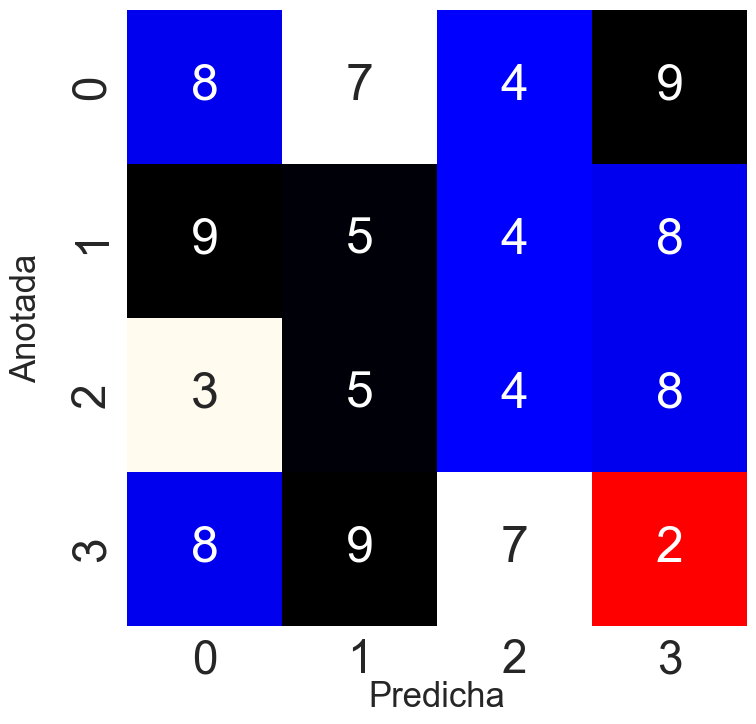

In [2]:
import random
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    confusion_matrix,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score
)


# Numero de muestras
n =  
nclases = 3

# A falta de clasificador y conjunto de datos, creamos anotaciones y predicciones de forma aleatoria
# Vector aleatorio con etiquetas anotadas
y = [random.randint(0, nclases - 1) for _ in range(n)]

# Vector aleatorio con etiquetas predichas por un supuesto clasificador
y_pred = [random.randint(0, nclases - 1) for _ in range(n)]


accuracy = accuracy_score(y, y_pred)
#Para más de una clase se define la forma de promediar
precision = precision_score(y, y_pred,average='weighted')
recall = recall_score(y, y_pred,average='weighted')
f1score = f1_score(y, y_pred,average='weighted')

print(f"Accuracy (TP/(n))= {accuracy}")
print(f"Precision (TP/(TP+FP)) = {precision}")
print(f"Recall (TP/(TP+FN)) = {recall}")
print(f"F1 Score (2*(precision*recall)/(precision+recall)) = {f1score}")


conf_matrix = confusion_matrix(y, y_pred)
plt.figure(figsize=(8,8))
sns.set(font_scale = 1.75)#tamaños tipografía
sns.set(font_scale = 3.0)

ax = sns.heatmap(
        conf_matrix, # confusion matrix 2D array 
        annot=True, # Muestra números en las celdas
        fmt='d', # valores enteros
        cbar=False, # sin barra de colores
        cmap='flag', # mapa de colores
        #vmax=175 # contraste de color
    )

#Etiquetas matriz de confusión
label_font = {'size':'25'}
ax.set_xlabel("Predicha", labelpad=-0.75, fontdict=label_font)
ax.set_ylabel("Anotada", labelpad=20, fontdict=label_font)
